In [1]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.io as pio
import data_parser
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind, ks_1samp, spearmanr  # For One-way ANOVA (which will compare groups in pairs)
from scipy.stats import ks_2samp  # Kolmogorov-Smirnov test
pio.renderers.default = "browser"
# Show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_rows", 30)
dpi=300


# Load Data
parser = data_parser.DataParser()
df = pd.read_csv("data/all_feats/df_selected_feats.csv")  # dataframe for analysis
df = parser.rename_columns_df(df)
df_all = pd.read_csv(f'data/df_all_feats.csv')
pallete = "summer"

# Samples per paper
# samples_per_paper = df_all.groupby('paper_ID').size()
# samples_per_paper = pd.DataFrame(samples_per_paper.sort_values(ascending=False), columns=['values'])
# top3_paper_ids = samples_per_paper.index[0:3]
# top3_papers_doi = df_all[df_all['paper_ID'].isin(top3_paper_ids)].drop_duplicates(subset='paper_ID')[['paper_ID', 'doi']]
# print("Distinct papers", df_all['paper_ID'].nunique())
# # Plot the TreeMap
# plt.figure(figsize=(21, 9))
# ths = 2  # count ths
# # large_rectangles = samples_per_paper[samples_per_paper >= ths]
# samples_per_paper['label'] = ['' if value <= ths else value for value in samples_per_paper['values']]
# colors = sns.color_palette(pallete, len(samples_per_paper['values']))  # Choose a colormap for the TreeMap
# plt.rcParams.update({'font.size': 18})
# plt.yticks(fontsize=18)
# squarify.plot(sizes=samples_per_paper['values'], color=colors, alpha=0.7, label=samples_per_paper['label'])
# plt.axis('off')
# plt.savefig(f"images/samples_per_paper.png", bbox_inches='tight', dpi=dpi)
# plt.show()



# Sample count per paper : by sample count and by country
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create output directory
images_dir = "images/data_analysis"
os.makedirs(images_dir, exist_ok=True)


In [2]:
fontsize = 22



In [3]:
features = parser.all_feats + parser.not_used_features
# Count both NaN and 0 as missing
missing_perc = ((df_all[features].isna() | (df_all[features] == 0)).mean() * 100).round(0).astype(int)
missing_perc = missing_perc.sort_values(ascending=False)
print(missing_perc)





technique         87
direction         87
cooling_rate      84
name_part2        72
name_part2        72
wf_bind_1         58
temp_cold         52
name_bind1        51
time_sub          48
wf_disp_1         41
name_disp_1       31
time_sinter_1     23
dia_part_1        23
temp_sinter_1     13
porosity           0
vf_total           0
material_group     0
name_fluid1        0
name_part1         0
dtype: int32



📊 Samples per Paper - Binned Distribution:
  Sample Count Bin  Paper Count  Total Samples in Bin Total % of Samples
0              1–5          125                   402                22%
1             6–10           82                   624                34%
2            11–20           35                   496                27%
3            21–30            6                   157                 8%
4            31–50            3                   123                 7%
5              51+            1                    57                 3%


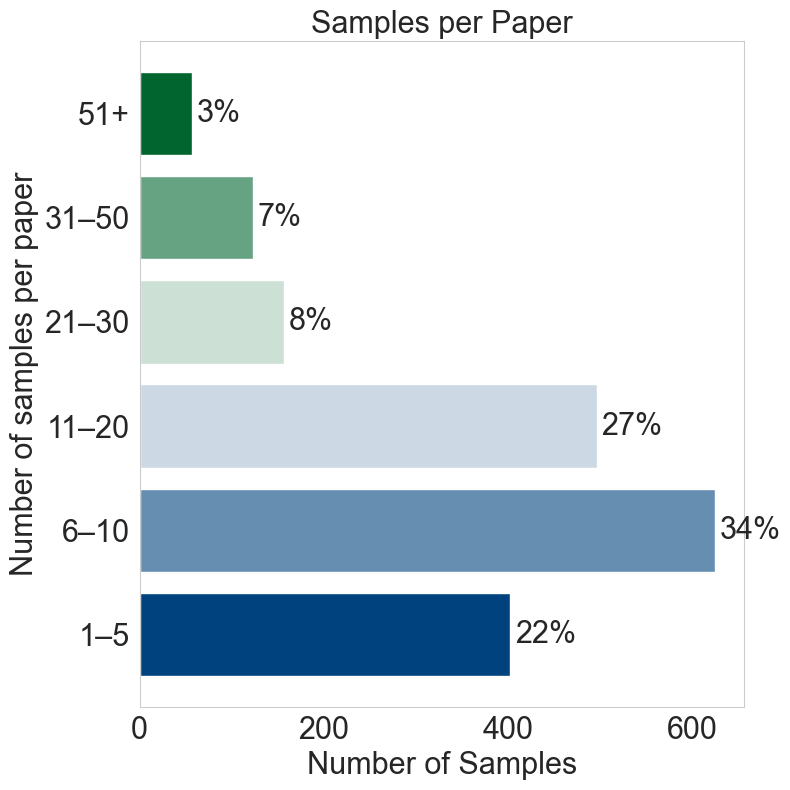

In [4]:
samples_per_paper = df_all.groupby('paper_ID').size()
bins = [0, 5, 10, 20, 30, 50, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–30', '31–50', '51+']
binned = pd.cut(samples_per_paper, bins=bins, labels=labels, right=True)
bin_counts = binned.value_counts(sort=False)
total_samples = samples_per_paper.sum()
bin_samples = samples_per_paper.groupby(binned).sum()
bin_percent = (100 * bin_samples / total_samples).round(0).astype(int)
bin_table = pd.DataFrame({
    'Sample Count Bin': labels,
    'Paper Count': bin_counts.values,
    'Total Samples in Bin': bin_samples.values,
    'Total % of Samples': [f"{p}%" for p in bin_percent.values]
})
print("\n📊 Samples per Paper - Binned Distribution:")
print(bin_table)
n_bins = len(labels)
cmap = LinearSegmentedColormap.from_list('green_blue', ["#00427d", "#ffffff", "#00652e"], N=n_bins)
colors2 = ["#00427d", "#00652e", "#E84855", "#f9dc5c", "#efbcd5", "#A9F0D1", "#461220", "#A37C40", "#BFCDE0", "#E3D26F"]

colors = [cmap(i / (n_bins - 1)) for i in range(n_bins)]

fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor('white')     # White figure background
ax.set_facecolor('white')            # White plot background
ax.grid(False)                       # Remove grid

bars = ax.barh(bin_table['Sample Count Bin'], bin_table['Total Samples in Bin'], color=colors)
for bar, pct in zip(bars, bin_percent.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2,
            f"{pct}%", va='center', fontsize=fontsize)
ax.set_xlabel("Number of Samples", fontsize=fontsize)
ax.set_ylabel("Number of samples per paper", fontsize=fontsize)
ax.set_title("Samples per Paper", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
plt.tight_layout()
plt.savefig(os.path.join(images_dir, "samples_per_paper_binned.png"), dpi=dpi)
plt.show()



🌍 Samples per Country (Top 9 + Others):
    Country  Sample Count Total % of Samples
0  PR China           580                31%
1       USA           439                24%
2  R. Korea           246                13%
3     Japan           147                 8%
4      Iran            93                 5%
5   Germany            66                 4%
6        UK            65                 3%
7     Italy            48                 3%
8    Brazil            38                 2%
9    Others           137                 7%


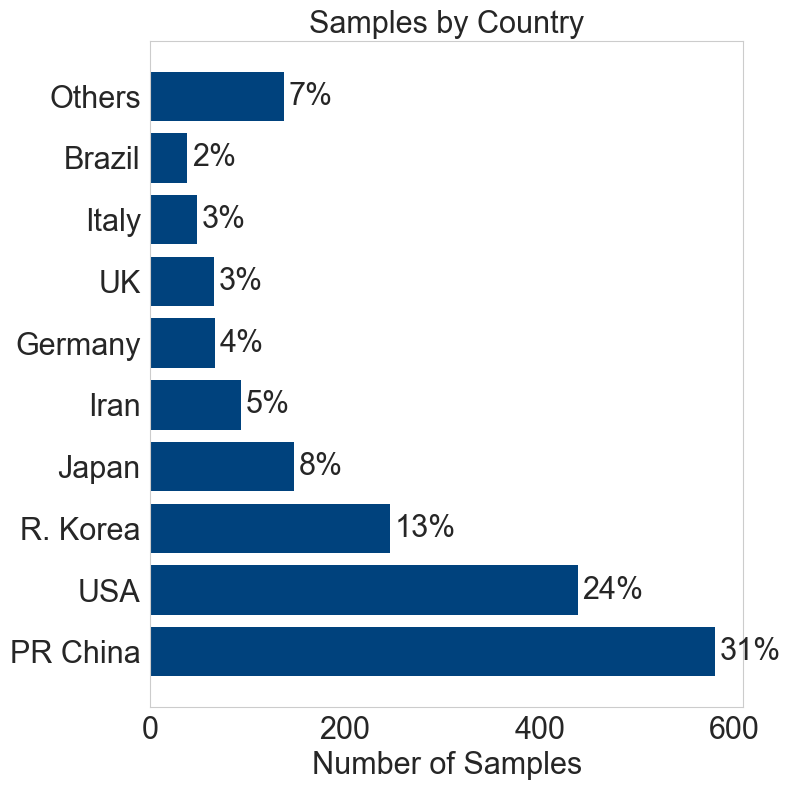

In [5]:
samples_by_country = df_all['country'].value_counts()
country_percent = (100 * samples_by_country / len(df_all)).round(0).astype(int)

# Separate top 9 countries
top9 = samples_by_country.head(9)
top9_percent = country_percent.loc[top9.index]

# Group remaining as "Others"
others_count = samples_by_country.iloc[9:].sum()
others_percent = country_percent.iloc[9:].sum()

# Build combined DataFrame
country_table = pd.DataFrame({
    'Country': list(top9.index) + ['Others'],
    'Sample Count': list(top9.values) + [others_count],
    'Total % of Samples': list(top9_percent.astype(str) + '%') + [f"{others_percent}%"]
})
country_table['Country'] = country_table['Country'].replace('Republic of Korea', 'R. Korea')
print("\n🌍 Samples per Country (Top 9 + Others):")
print(country_table)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)

bars = ax.barh(
    country_table['Country'],
    country_table['Sample Count'],
    color="#00427d",
    edgecolor='none'  # removes black contour
)

ax.set_yticklabels(country_table['Country'], fontsize=fontsize)
ax.set_xlabel("Number of Samples", fontsize=fontsize)
ax.set_title("Samples by Country", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)

for bar, pct in zip(bars, [*top9_percent.values, others_percent]):
    if pct >= 1:
        ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2,
                f"{pct}%", va='center', fontsize=fontsize)

plt.tight_layout()
plt.savefig(os.path.join(images_dir, "samples_by_country_top9_others.png"), dpi=dpi, bbox_inches='tight')
plt.show()




In [6]:
# Temp sinter
max_temp_sinter1_row = df_all[df_all['temp_sinter_1'] == df_all['temp_sinter_1'].max()]
doi_with_max_temp_sinter1 = max_temp_sinter1_row['doi'].values[0]
print("DOI with the maximum 'temp_sinter1':", doi_with_max_temp_sinter1)

# Null counts
print(df.head())
print(f"Count of Null values out of {len(df_all)} rows \n", df_all.isnull().sum())
nulls = round(df_all.isnull().mean() * 100, 2)
selected_nulls = nulls[parser.all_feats]
print(f"\nPercentage of Null Values:\n", round(df_all.isnull().mean() * 100, 2), "%")
zero_nan_percentage = ((df_all['cooling_rate'].isna() | (df_all['cooling_rate'] == 0)).mean()) * 100
print(f"Percentage of 0 or NaN in 'cooling_rate': {zero_nan_percentage:.2f}%")




DOI with the maximum 'temp_sinter1': 10.1021/acsami.5b11120
  Solid Name Solid Name 2 Fluid Name  Solid Diameter          Group     Disp. Name  Disp. wf.  Binder wf.  Temp. Cold  Time Sinter.  Temp Sinter  Solid Loading  Porosity
0       ZrO2         Y2O3      water    6.000000e-05        Ceramic            NOI     0.0260         NaN       243.0           2.0       1823.0         0.1607    0.5679
1        YSZ          NaN      water    7.000000e-07        Ceramic         NH4PAA     0.0065        0.03         NaN           NaN        773.0         0.1100    0.7600
2        YSZ          NaN      water    1.000000e-07        Ceramic         NH4PAA     0.0065        0.03         NaN           NaN        773.0         0.1100    0.7000
3        YSZ          NaN      water    3.000000e-07  Metal/Ceramic  Dolapix CE 64        NaN         NaN         NaN           3.0       1173.0         0.2000    0.6420
4    gelatin          NaN      water    0.000000e+00        Polymer            NaN        

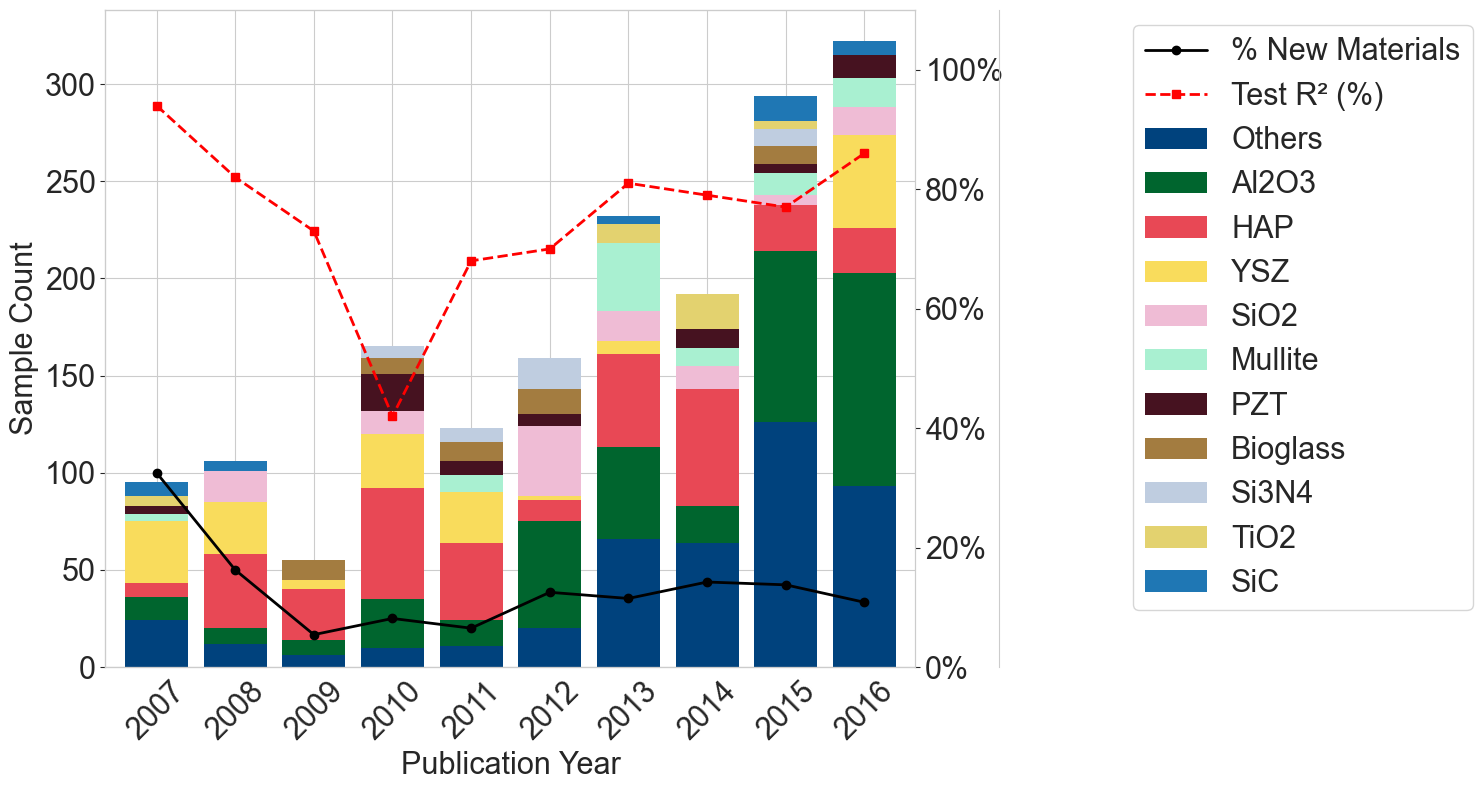

In [7]:
# Year Plot
import pandas as pd

def plot_samples_and_new_materials(df, feature, top_n=5, output_path=None, n_years=15):
    df = df[['year', feature]].dropna()
    df['year'] = df['year'].astype(int)
    df = df[df['year'].isin(sorted(df['year'].unique())[-n_years:])]

    top_materials = df[feature].value_counts().nlargest(top_n).index
    df['material_grouped'] = df[feature].where(df[feature].isin(top_materials), 'Others')

    year_material_counts = df.groupby(['year', 'material_grouped']).size().unstack(fill_value=0).sort_index()
    total_counts = year_material_counts.sum(axis=0).sort_values(ascending=False)
    year_material_counts = year_material_counts[total_counts.index]

    seen = set()
    pct_new_by_year = {}
    for year in sorted(df['year'].unique()):
        current = set(df[df['year'] == year][feature])
        new = current - seen
        pct_new_by_year[year] = 100 * len(new) / len(current) if current else 0
        seen |= current
    pct_new_series = pd.Series(pct_new_by_year)

    n_colors = min(top_n + 1, len(year_material_counts.columns))
    base_colors = colors2[:n_colors]
    if n_colors > len(colors2):
        base_colors += sns.color_palette('tab10', n_colors=n_colors - len(colors2))

    fig, ax1 = plt.subplots(figsize=(16, 8))
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    ax1.grid(False)

    bars = year_material_counts.plot(kind='bar', stacked=True, ax=ax1, width=0.8, color=base_colors, zorder=2, edgecolor='none')

    x_pos = range(len(year_material_counts.index))
    y_line = pct_new_series.loc[year_material_counts.index].values
    line, = ax1.plot(x_pos, y_line, color='black', marker='o', linestyle='-', linewidth=2, markersize=6,
                     label='% New Materials', zorder=3)

    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(year_material_counts.index, rotation=45, fontsize=fontsize)
    ax1.set_ylabel("Sample Count", fontsize=fontsize)
    ax1.set_xlabel("Publication Year", fontsize=fontsize)
    ax1.tick_params(labelsize=fontsize)

    # Secondary axis for % new materials
    ax2 = ax1.twinx()
    ax2.set_facecolor('white')
    ax2.grid(False)
    ax2.set_ylim(0, 110)
    ax2.tick_params(labelsize=fontsize)
    ax2.set_yticks(range(0, 111, 20))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}%"))

    # Add R² (hardcoded, scaled to %)
    r2_by_year = {
        2007: 94,
        2008: 82, 2009: 73, 2010: 42, 2011: 68, 2012: 70,
        2013: 81, 2014: 79, 2015: 77, 2016: 86
    }
    r2_values = [r2_by_year.get(y, None) for y in year_material_counts.index]
    valid_idx = [i for i, v in enumerate(r2_values) if v is not None]
    x_r2 = [x_pos[i] for i in valid_idx]
    y_r2 = [r2_values[i] for i in valid_idx]

    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.set_facecolor('white')
    ax3.grid(False)
    r2_line, = ax3.plot(x_r2, y_r2, color='red', linestyle='--', marker='s', linewidth=2,
                        markersize=6, label='Test R² (%)', zorder=4)
    ax3.set_ylim(0, 110)
    # Remove ticks on ax3
    ax3.tick_params(left=False, right=False, labelleft=False, labelright=False)

    # Combine all legends with correct order
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles_ordered = [line, r2_line] + [h for l, h in zip(labels1, handles1) if l not in ['% New Materials', 'Test R² (%)']]
    labels_ordered = ['% New Materials', 'Test R² (%)'] + [l for l in labels1 if l not in ['% New Materials', 'Test R² (%)']]
    ax1.legend(handles_ordered, labels_ordered, loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=fontsize)

    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
    plt.show()

# Example call (replace with your actual DataFrame and column)
# Assumes you have a DataFrame `df` with columns like 'year' and 'name_part1'
plot_samples_and_new_materials(df_all, feature='name_part1', top_n=10, n_years=10, output_path=images_dir + "/samples_per_year.png")









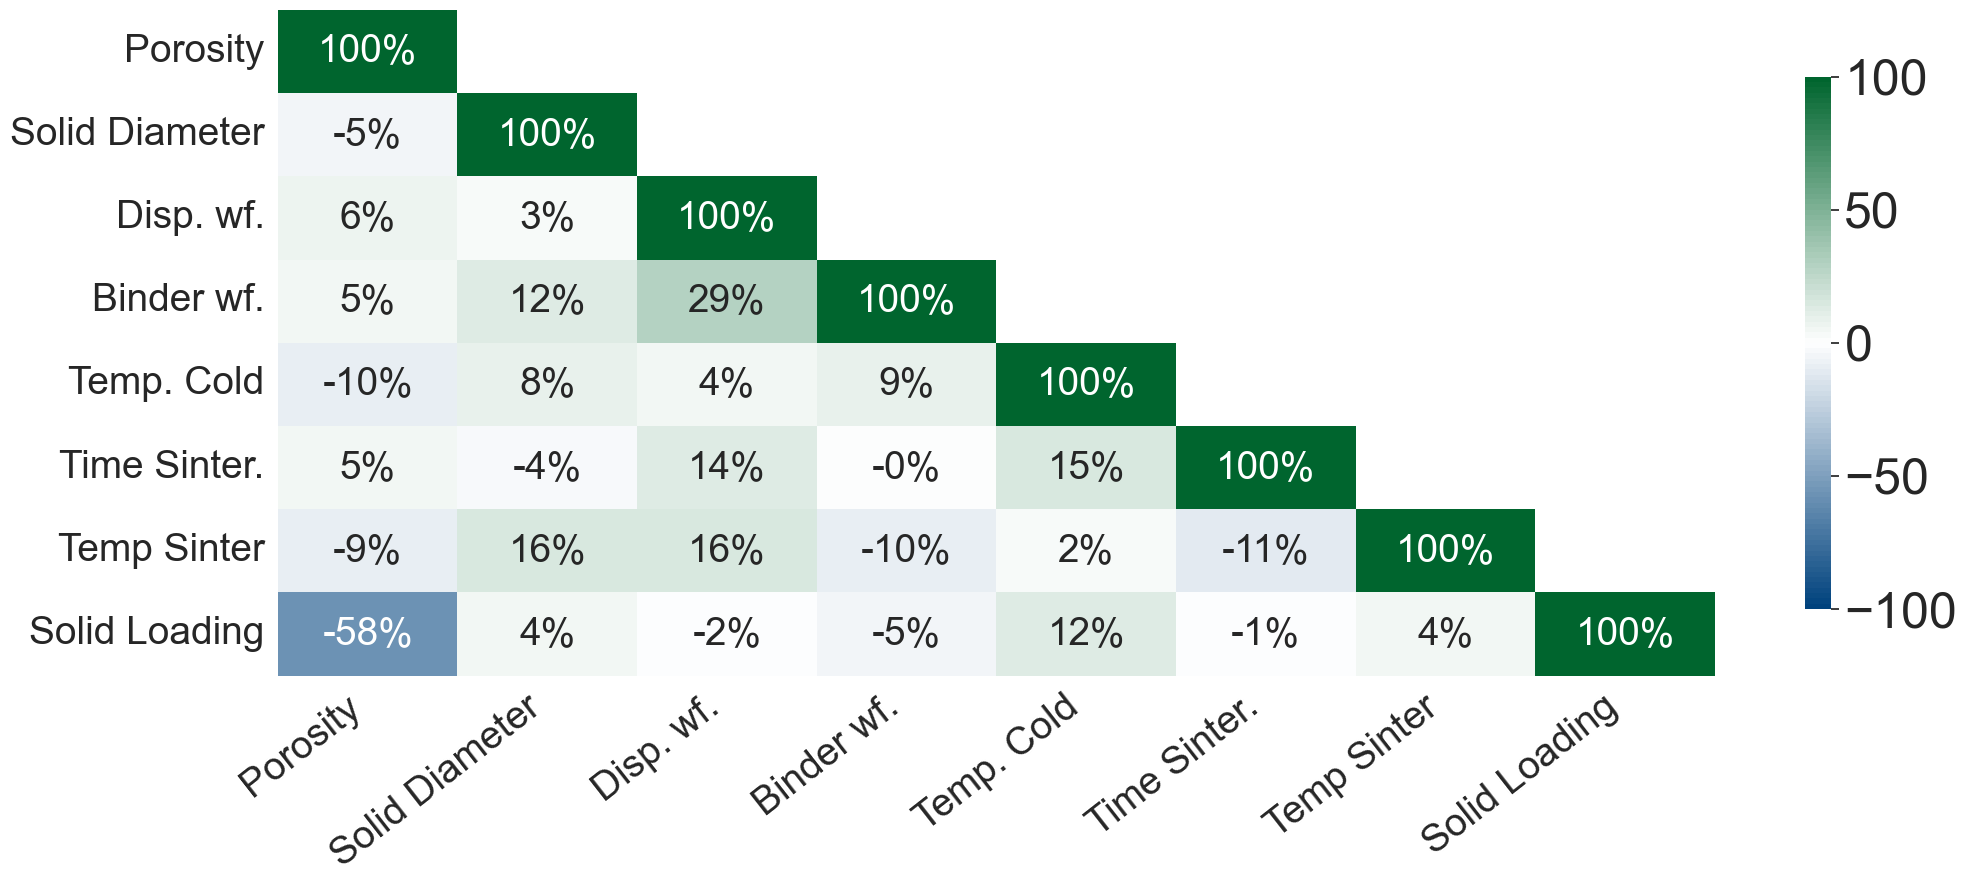

In [8]:

# Calculate the correlation matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap (green, yellow, red with transparency)
n_bins = 100
cmap = LinearSegmentedColormap.from_list('green_yellow_red_transparent',
                                         ['#ff6b6b', '#ffffff',  '#aed476'], N=n_bins)
cmap = LinearSegmentedColormap.from_list('green_blue', [ "#00427d", '#ffffff', "#00652e"], N=n_bins)


# Calculate the correlation matrix
df_num = df.select_dtypes(include=['number', 'float64']).copy()
cols = ['Porosity'] + [col for col in df_num.columns if col != 'Porosity']
df_num = df_num[cols]
corr = df_num.corr()


# Optional: use Spearman's correlation
# corr, _ = spearmanr(df_num)  # Calculate Spearman correlation, the second value is p-values

corr = np.round(corr * 100, 0)  # Use np.round to round values to the nearest integer

# Masking the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot
plt.figure(figsize=(21, 9))
# Set the style to 'white' to remove grid and background
sns.set(style="white")

# Plotting the heatmap with the custom colormap
heatmap = sns.heatmap(corr,
                      vmin=-100, vmax=100,
                      mask=mask,
                      annot=True,
                      cmap=cmap,  # Apply the custom colormap
                      fmt=".0f",  # Display values as integers
                      annot_kws={"fontsize": 28},
                      cbar_kws={'shrink': 0.8})  # Adjust colorbar size

# Format the annotations to include '%' sign
for text in heatmap.texts:
    text.set_text(f"{text.get_text()}%")  # Add '%' after each number

# Remove grid and background
heatmap.grid(False)

# Increase colorbar fontsize
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=36)  # Increase colorbar fontsize

# Adjust tick labels' font size and rotation
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=28)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=28)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=38, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

# Tight layout and show
plt.tight_layout()
# Save the plot
plt.savefig(f"images/Correlation.png", dpi=dpi)
plt.show()





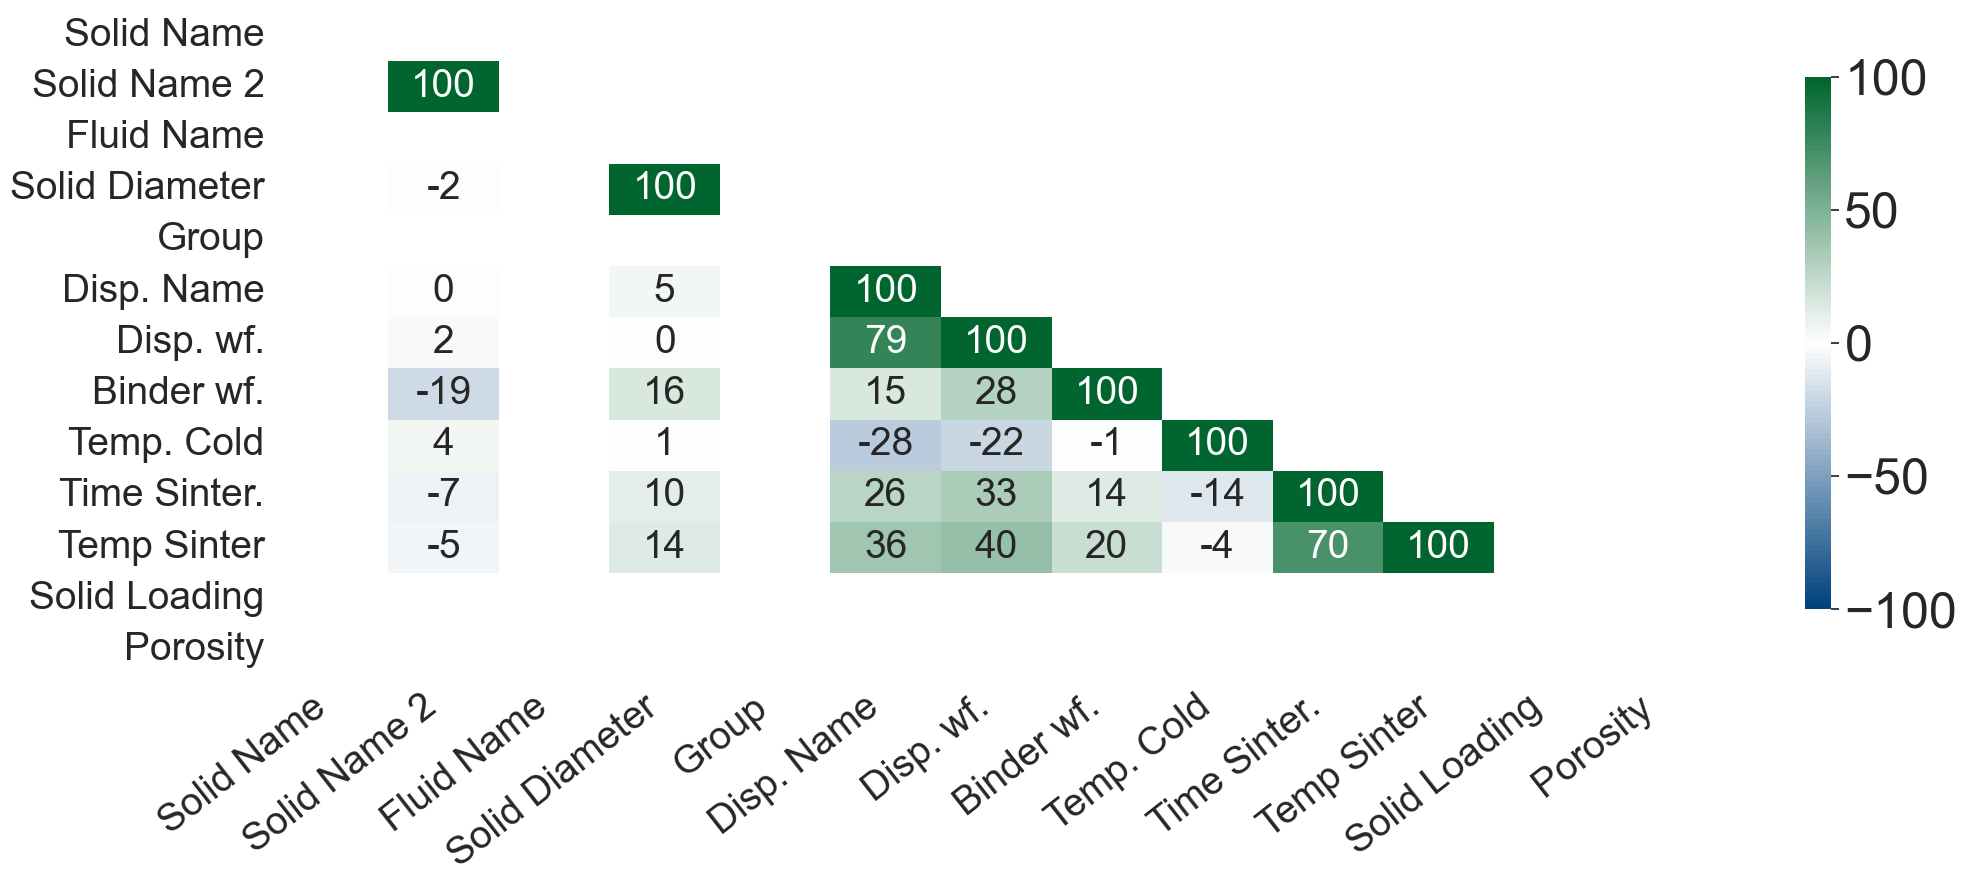

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(21, 9))

# Set the style to 'white' to remove grid and background
sns.set(style="white")

# Calculate the missing values correlation matrix
df_missing = df.isnull()  # Create a boolean DataFrame of missing values
corr_missing = df_missing.corr()  # Correlation of missing values
corr_missing = round(corr_missing * 100, 0)  # Multiply by 100 to get percentage

# Masking the upper triangle
mask = np.triu(np.ones_like(corr_missing, dtype=bool), k=1)

# Plotting the heatmap for missing values correlation
heatmap = sns.heatmap(corr_missing,
                      vmin=-100, vmax=100,
                      mask=mask,
                      annot=True,
                      cmap=cmap, #'BrBG',
                      fmt=".0f",  # Display values as integers
                      annot_kws={"fontsize": 28},
                      cbar_kws={'shrink': 0.8})  # Adjust colorbar size

# Remove grid and background
heatmap.grid(False)

# Increase colorbar fontsize
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=36)  # Increase colorbar fontsize

# Adjust tick labels' font size and rotation
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=28)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=28)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=38, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

# Tight layout and show
plt.tight_layout()
plt.show()
plt.savefig(f"images/Correlation_missing.png", dpi=dpi)


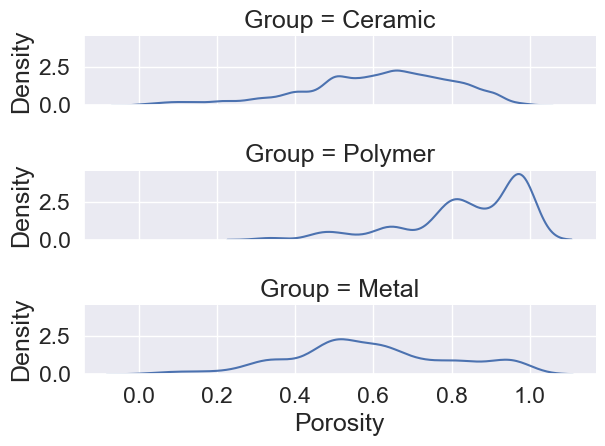

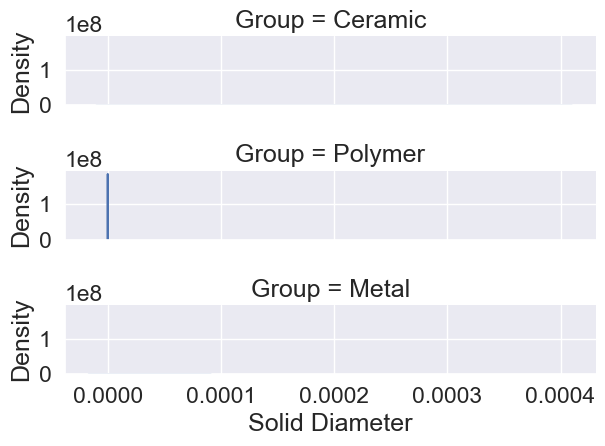

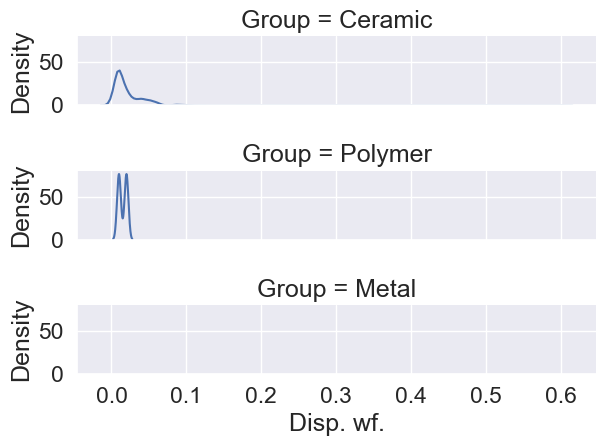

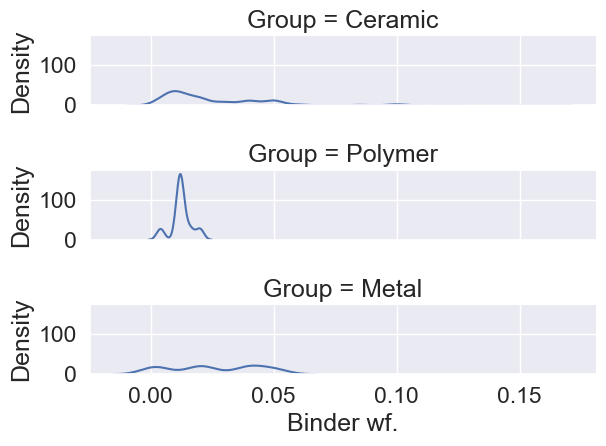

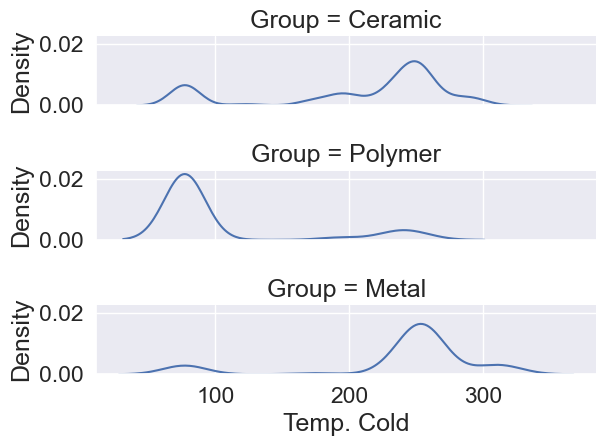

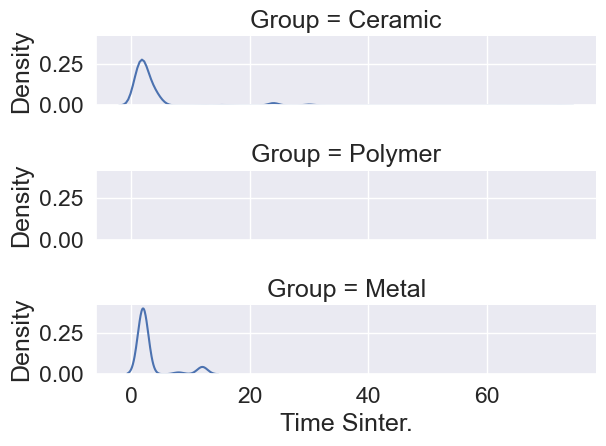

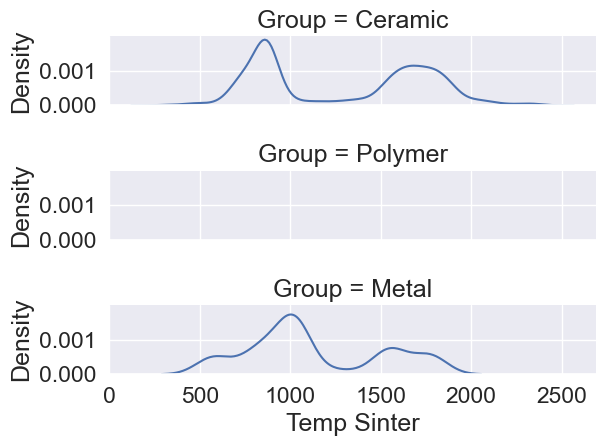

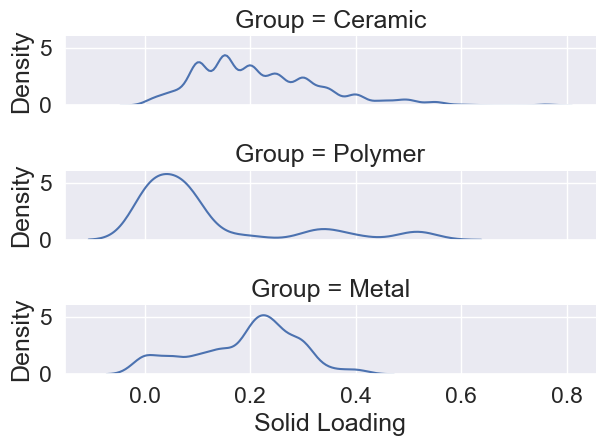

In [10]:

plt.close('all')
# Dist Plot Numerical
order = df['Group'].value_counts().index.to_list()
df['group_order'] = df['Group'].astype(pd.CategoricalDtype(categories=order, ordered=True))
df_num_dist = df.sort_values(by='group_order')  # order raw df for numerical distribution plot
top4_group_order_categories = df_num_dist['group_order'].value_counts().head(3).index.to_list()
df_num_dist_top4 = df_num_dist[df_num_dist['group_order'].isin(top4_group_order_categories)]
for col in df_num:
    sns.set(font_scale=1.5)
    g = sns.FacetGrid(df_num_dist_top4, row='Group',
                      height=1.6, aspect=4)
    g.map(sns.kdeplot, col, bw_adjust=.6)
    g.set_ylabels('Density')
    plt.savefig(f"images/num_dist_{col}.png", dpi=dpi)

# Initialize a dictionary to store p-values
p_values = {col: {} for col in df_num}

# Calculate p-values for each pair of groups for each numerical column
for col in df_num:
    for i, group1 in enumerate(top4_group_order_categories):
        for group2 in top4_group_order_categories[i+1:]:
            group1_data = df_num_dist_top4[df_num_dist_top4['Group'] == group1][col]
            group2_data = df_num_dist_top4[df_num_dist_top4['Group'] == group2][col]
            p_value = ks_2samp(group1_data, group2_data).pvalue
            p_values[col][(group1, group2)] = p_value

# Filter p-values to only show those above 1e-4
significance_threshold = 0.05
# significance_threshold = 1e-4
filtered_p_values = {col: {groups: p for groups, p in group_p_values.items() if p > significance_threshold} for col, group_p_values in p_values.items()}

# Print the sorted, filtered p-values
for key in filtered_p_values.keys():
    vals = filtered_p_values[key]
    for key2 in vals.keys():
        val2 = vals[key2]
        i# f val2 >= significance_threshold:
            # print(key, key2, val2)



Summary for Group:
                 Count  Mean_Porosity  STD_Porosity  Total%
Group                                                      
Ceramic           1587           61.0          19.0      85
Polymer             91           85.0          15.0       5
Metal               90           59.0          21.0       5
Ceramic/Polymer     45           72.0          21.0       2
Metal/Ceramic       40           24.0          21.0       2
Pharmaceutical       6           45.0           4.0       0


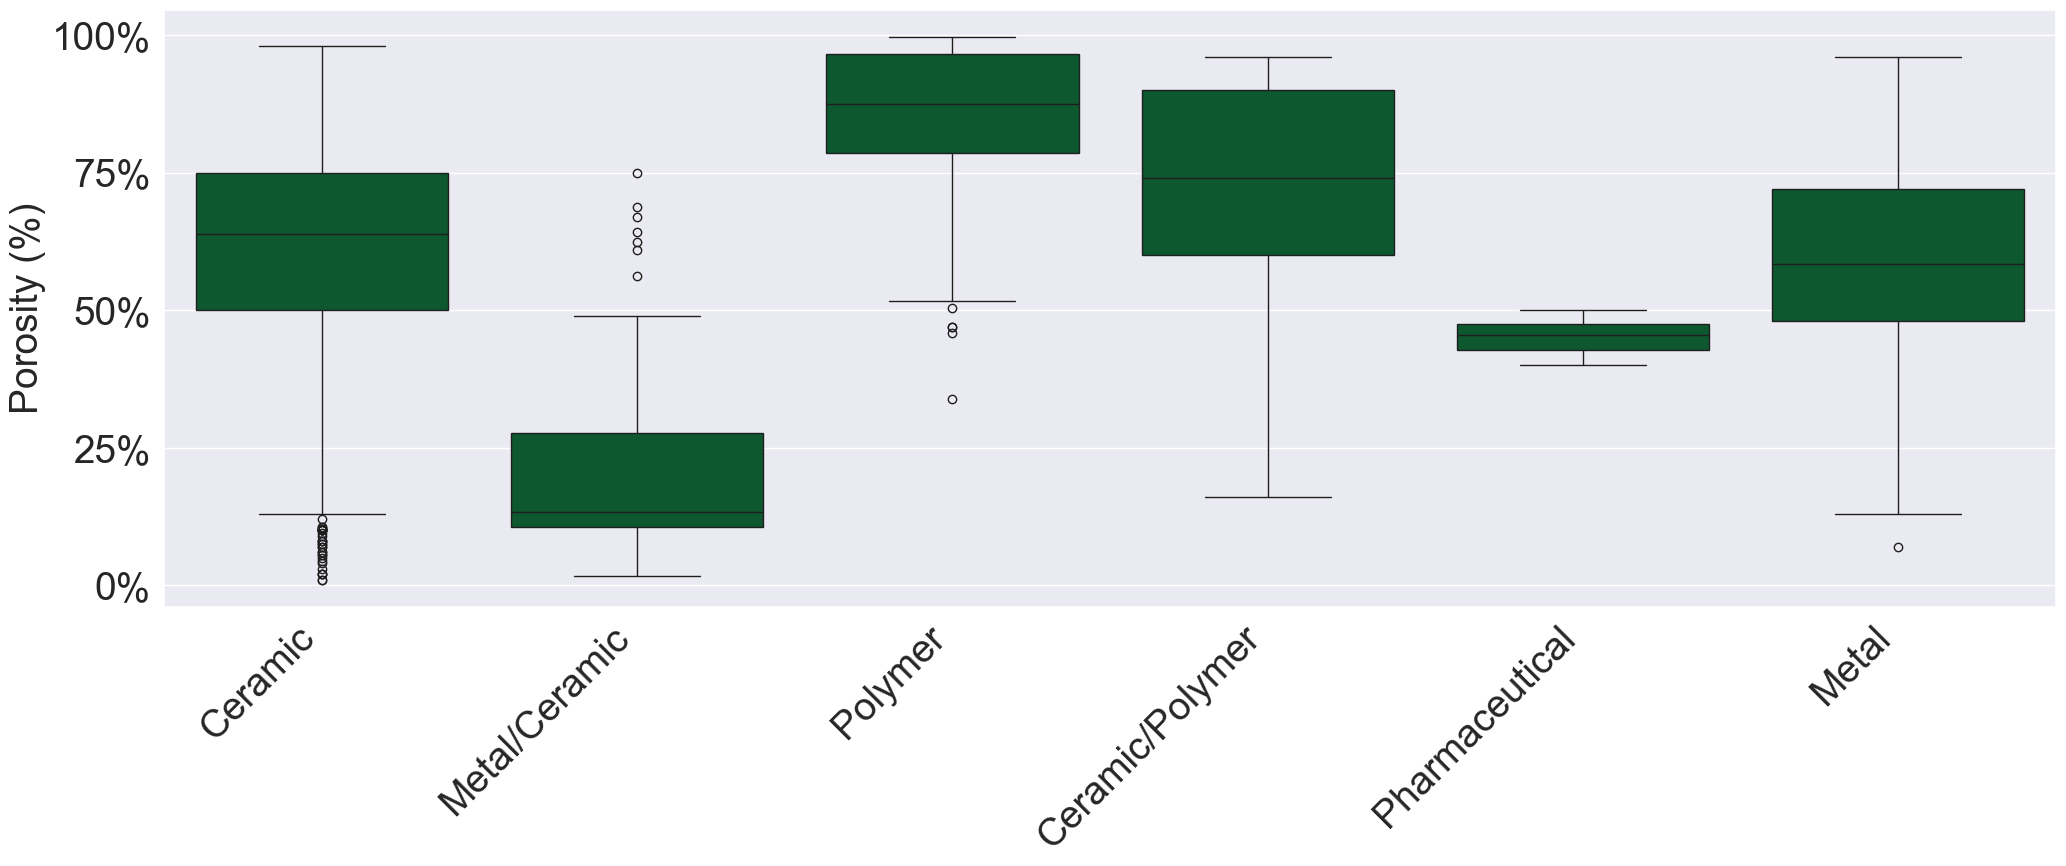


Summary for Solid Name:
            Count  Mean_Porosity  STD_Porosity  Total%
Solid Name                                            
Others        677           64.0          21.0      36
Al2O3         456           55.0          23.0      25
HAP           353           64.0          17.0      19
YSZ           180           61.0          18.0      10
SiO2          110           64.0          18.0       6
Mullite        83           63.0          12.0       4


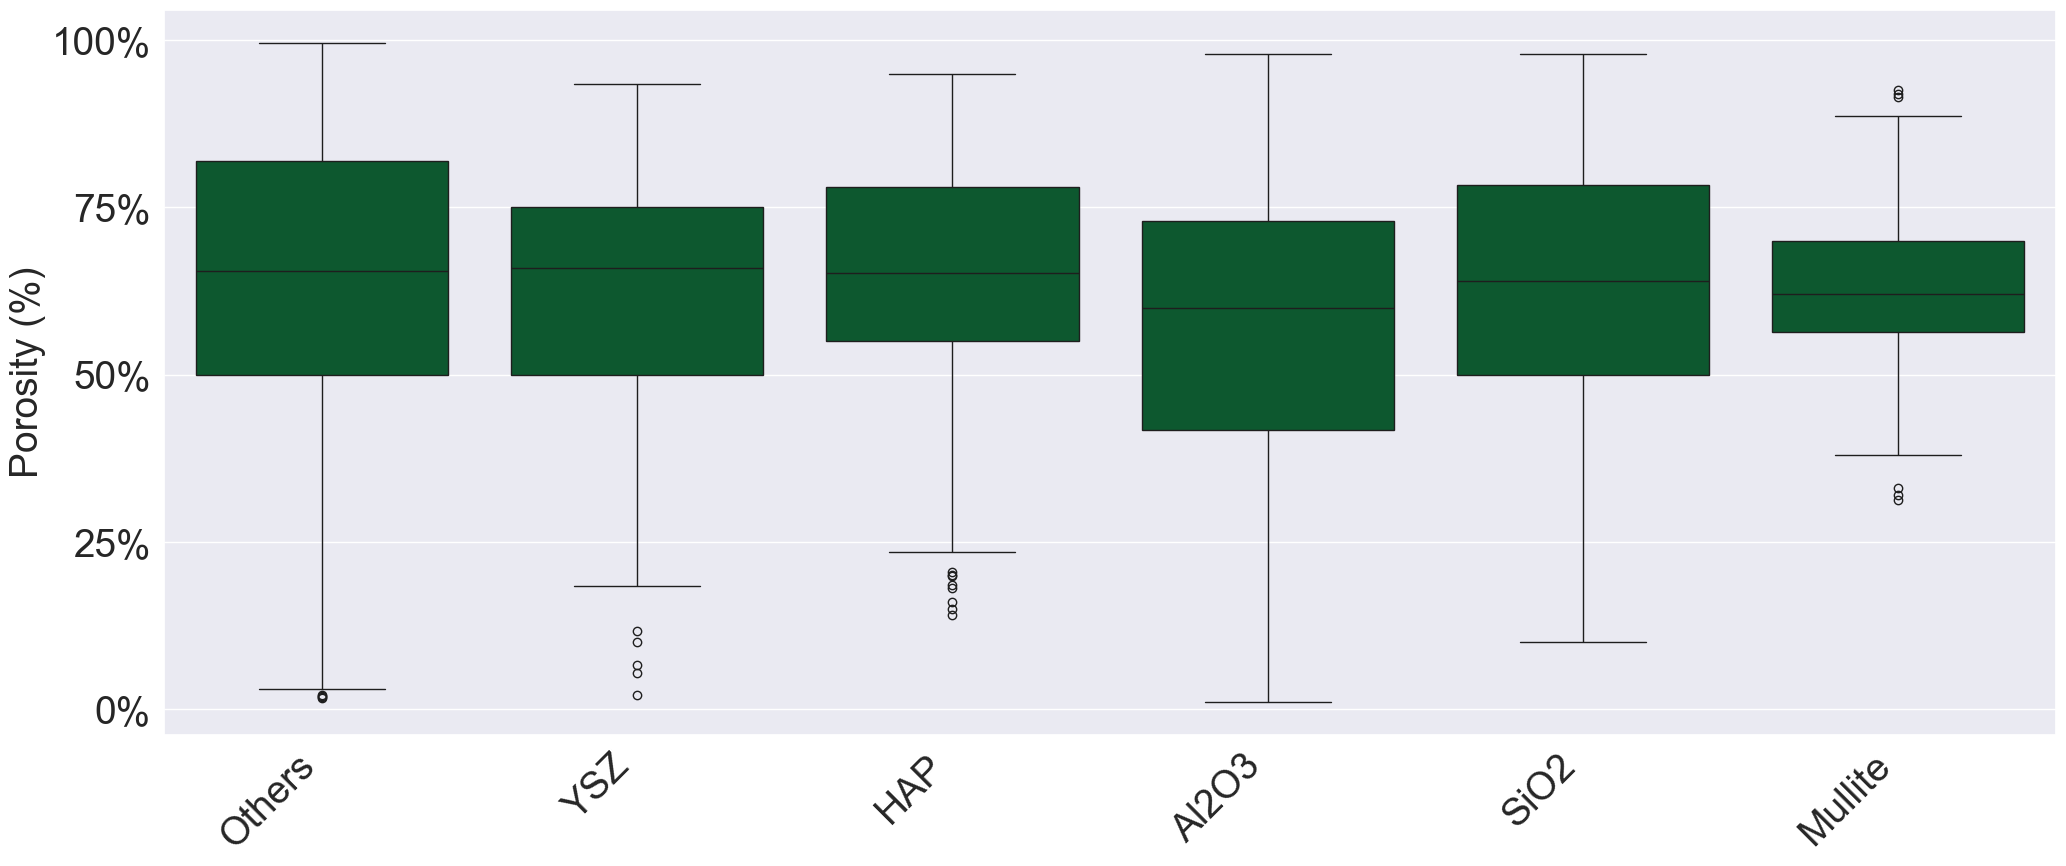


Summary for Fluid Name:
             Count  Mean_Porosity  STD_Porosity  Total%
Fluid Name                                             
water         1184           62.0          21.0      64
TBA            371           61.0          16.0      20
camphene       224           58.0          20.0      12
acetic acid     38           93.0           3.0       2
Others          30           70.0          18.0       2
naphthalene     12           28.0          22.0       1


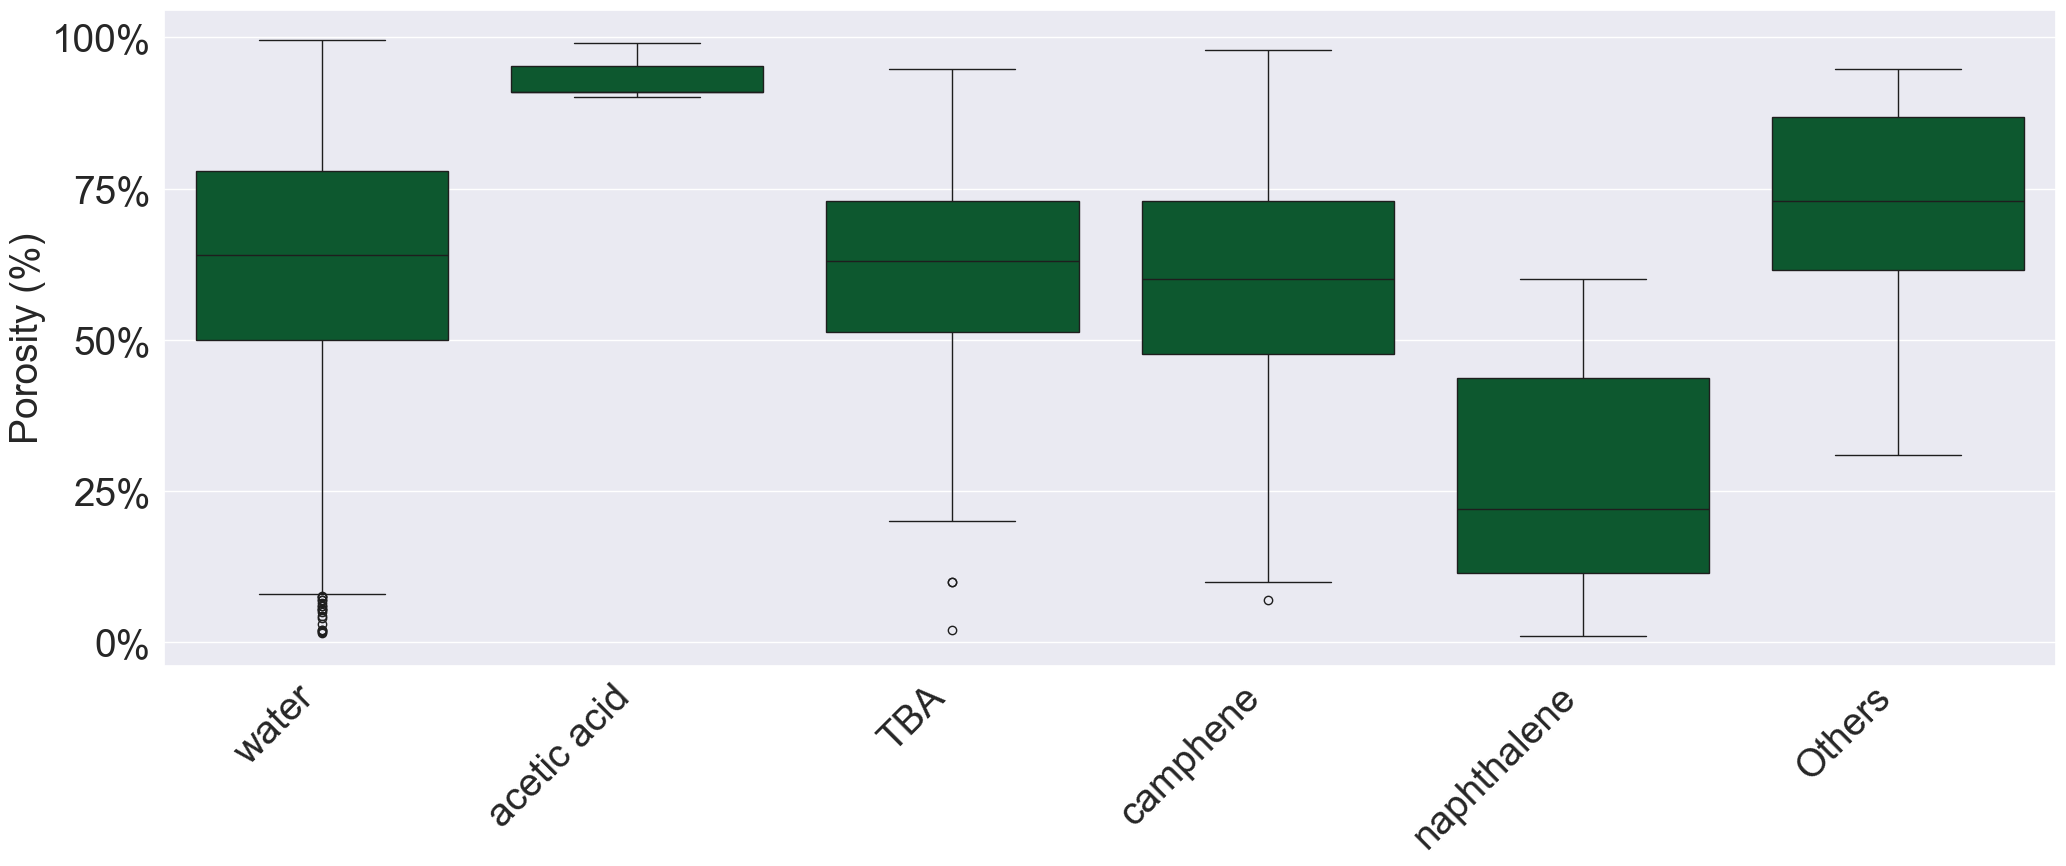

In [11]:
# List of categorical columns to use as the group
df = pd.read_csv("data/all_feats/df_selected_feats.csv")  # dataframe for analysis
df = parser.rename_columns_df(df)
df_str = (df.select_dtypes(include=[object]))
categorical_columns = df_str.columns.to_list()
categorical_columns = ["Group", "Solid Name", "Fluid Name"]

for col in categorical_columns:
    # Get category counts
    category_counts = df[col].value_counts()

    # Identify the top 4 categories and group the rest as "Others"
    top_categories = category_counts.index[:5]
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Others')
    if col == 'Group':
        df[col] = df[col].replace({'Others': 'Pharmaceutical'})


    # Compute aggregated statistics
    summary = df.groupby(col)['Porosity'].agg(
        Count='count',
        Mean_Porosity=lambda x: round(x.mean()*100, 0),
        STD_Porosity=lambda x: round(x.std()*100, 0)
    )

    # Compute percentage of total and round
    summary['Total%'] = round(((summary['Count'] / summary['Count'].sum()) * 100)).round().astype(int)

    # Print the table
    print(f"\nSummary for {col}:")
    print(summary.sort_values(by='Count', ascending=False).to_string())

    # Create the boxplot
    plt.figure(figsize=(21, 9))
    sns.boxplot(x=col, y='Porosity', data=df, color="#00652e")

    # Format y-axis as percentage
    plt.gca().set_ylabel('Porosity (%)', fontsize=28)  # Set y-axis label with fontsize 28
    plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])  # Define y-ticks
    plt.gca().set_yticklabels([f'{int(i * 100)}%' for i in [0, 0.25, 0.5, 0.75, 1]])  # Format as percentages

    # Set title and improve plot appearance
    # plt.title(f"Boxplot of Porosity by {col}", fontsize=28)
    plt.xticks(rotation=45, ha='right', fontsize=28)  # Rotate x labels for readability
    plt.yticks(fontsize=28)  # Set y-tick font size
    # plt.xlabel(col, fontsize=28)  # Set x-axis label
    plt.gca().set_xlabel('')  # Remove x-axis label
    plt.tight_layout()  # Ensure everything fits well within the plot
    plt.savefig(f"images/summary_of_{col}.png", dpi=dpi)
    # Display the plot
    plt.show()


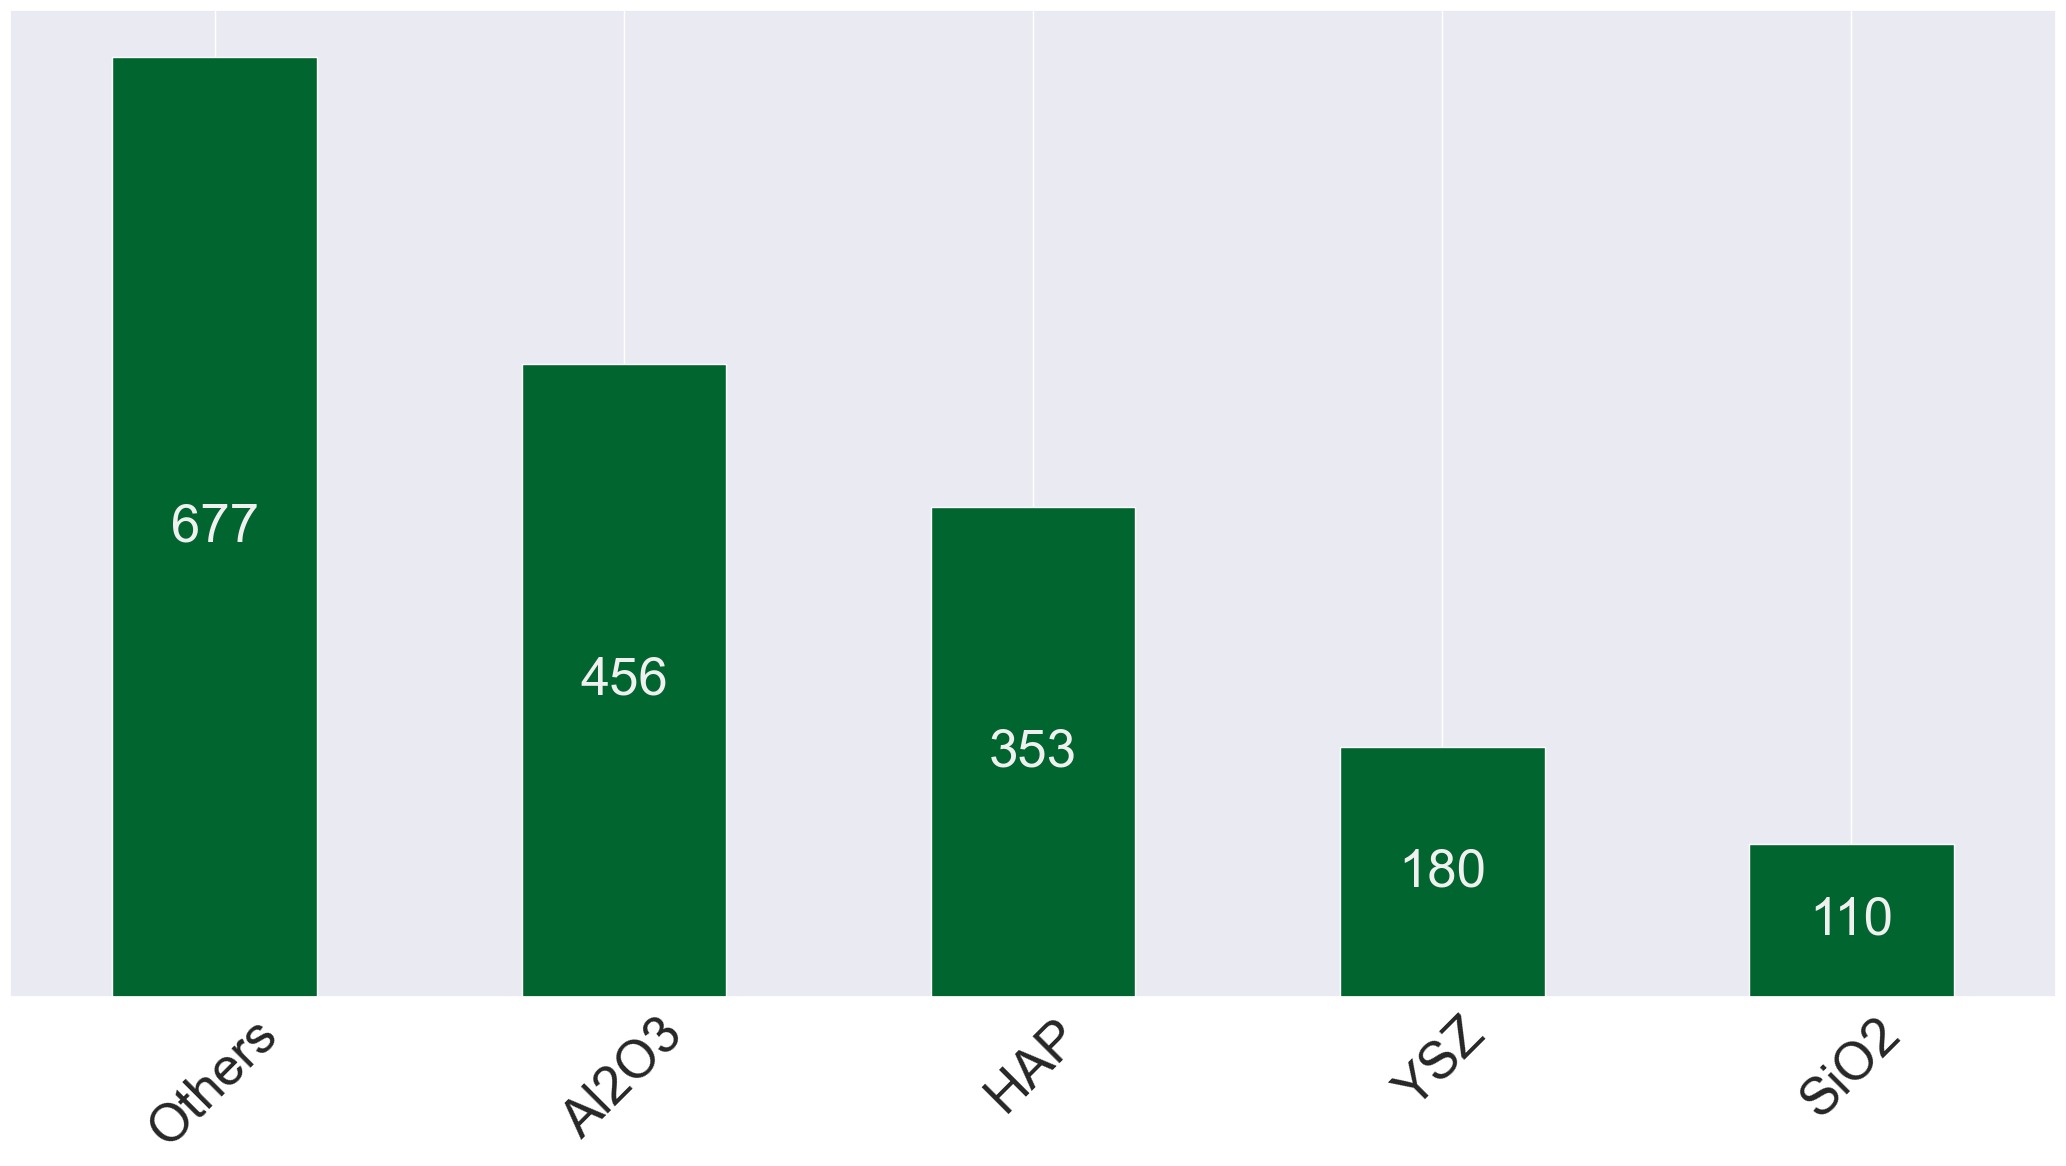

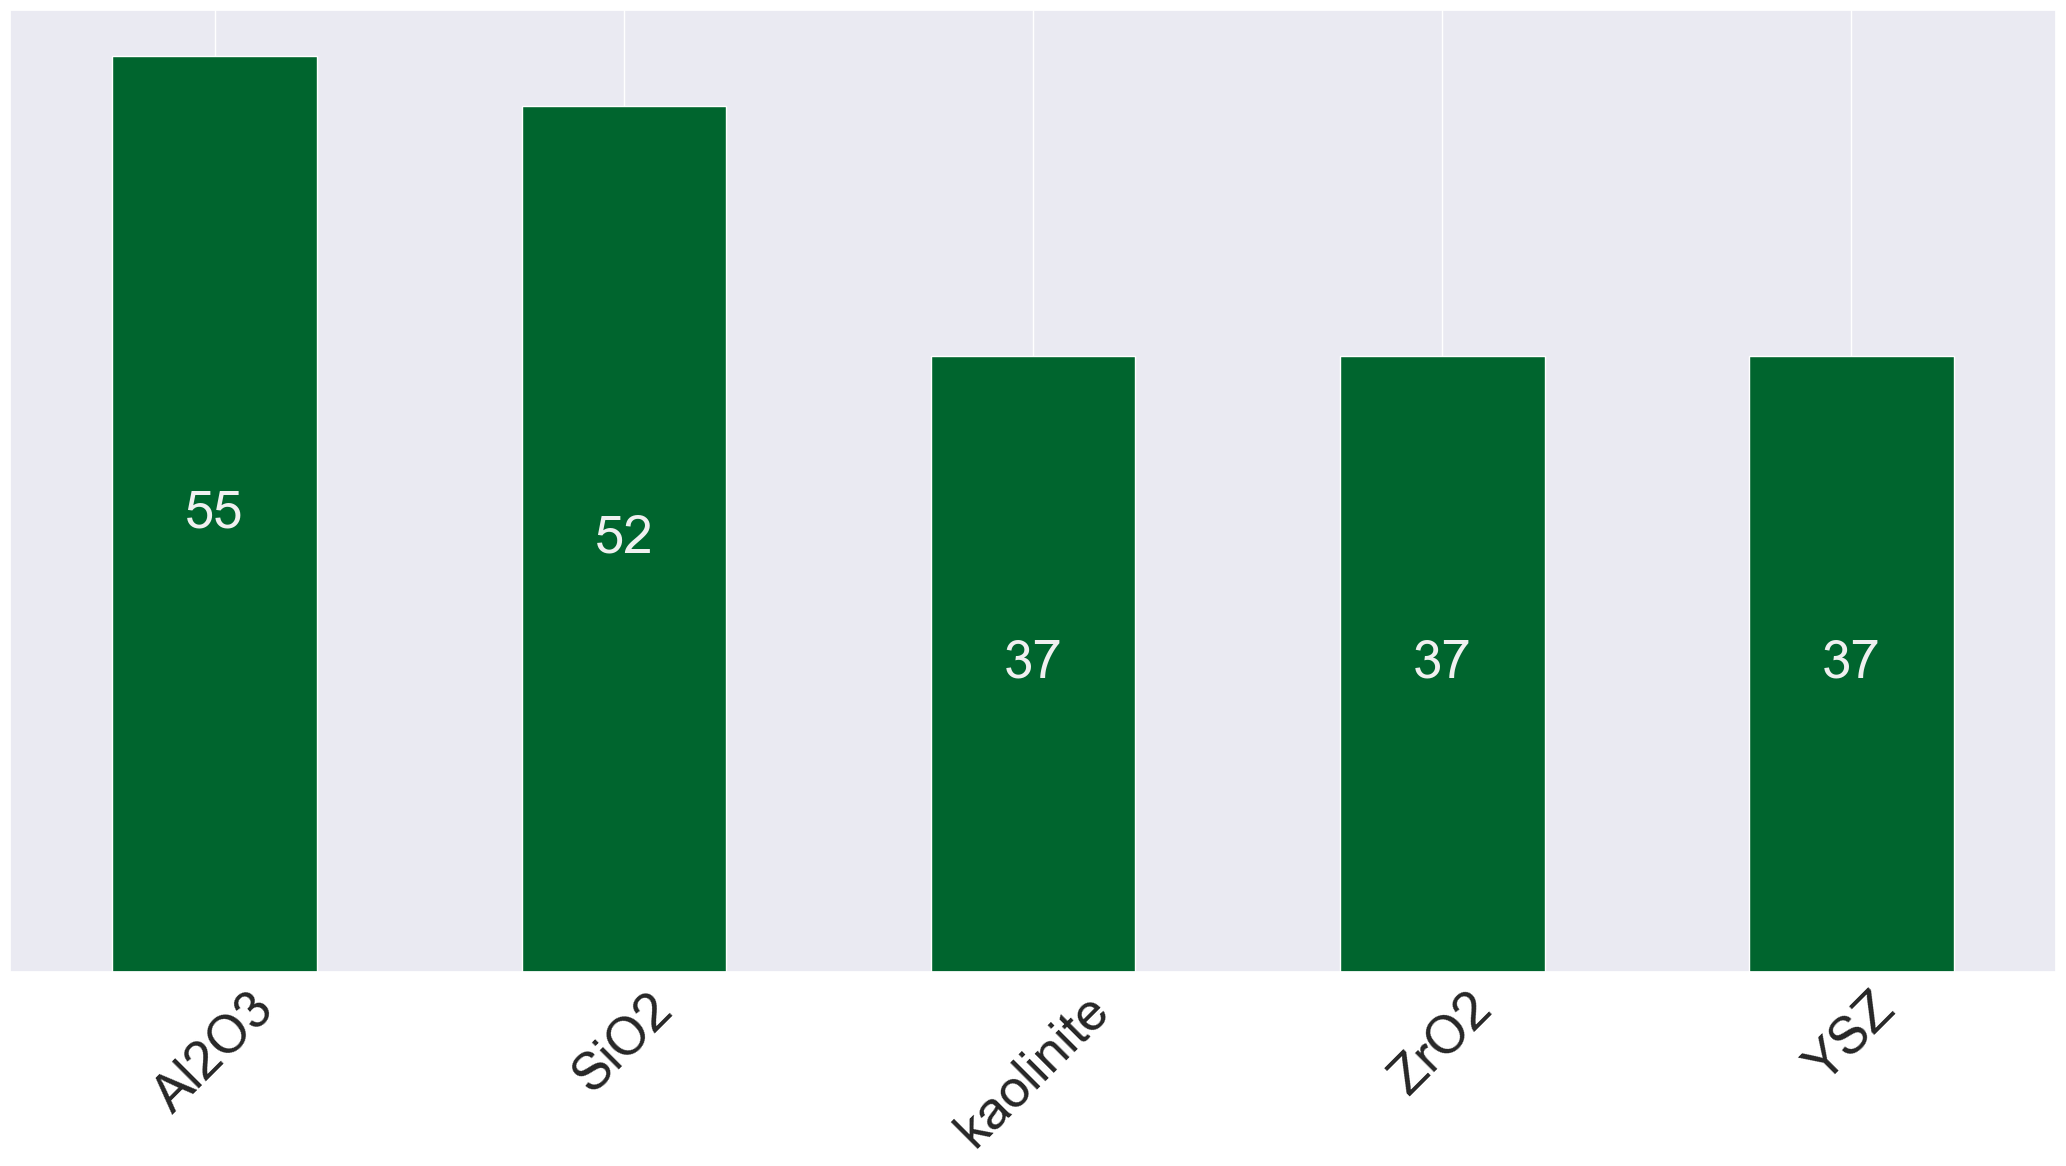

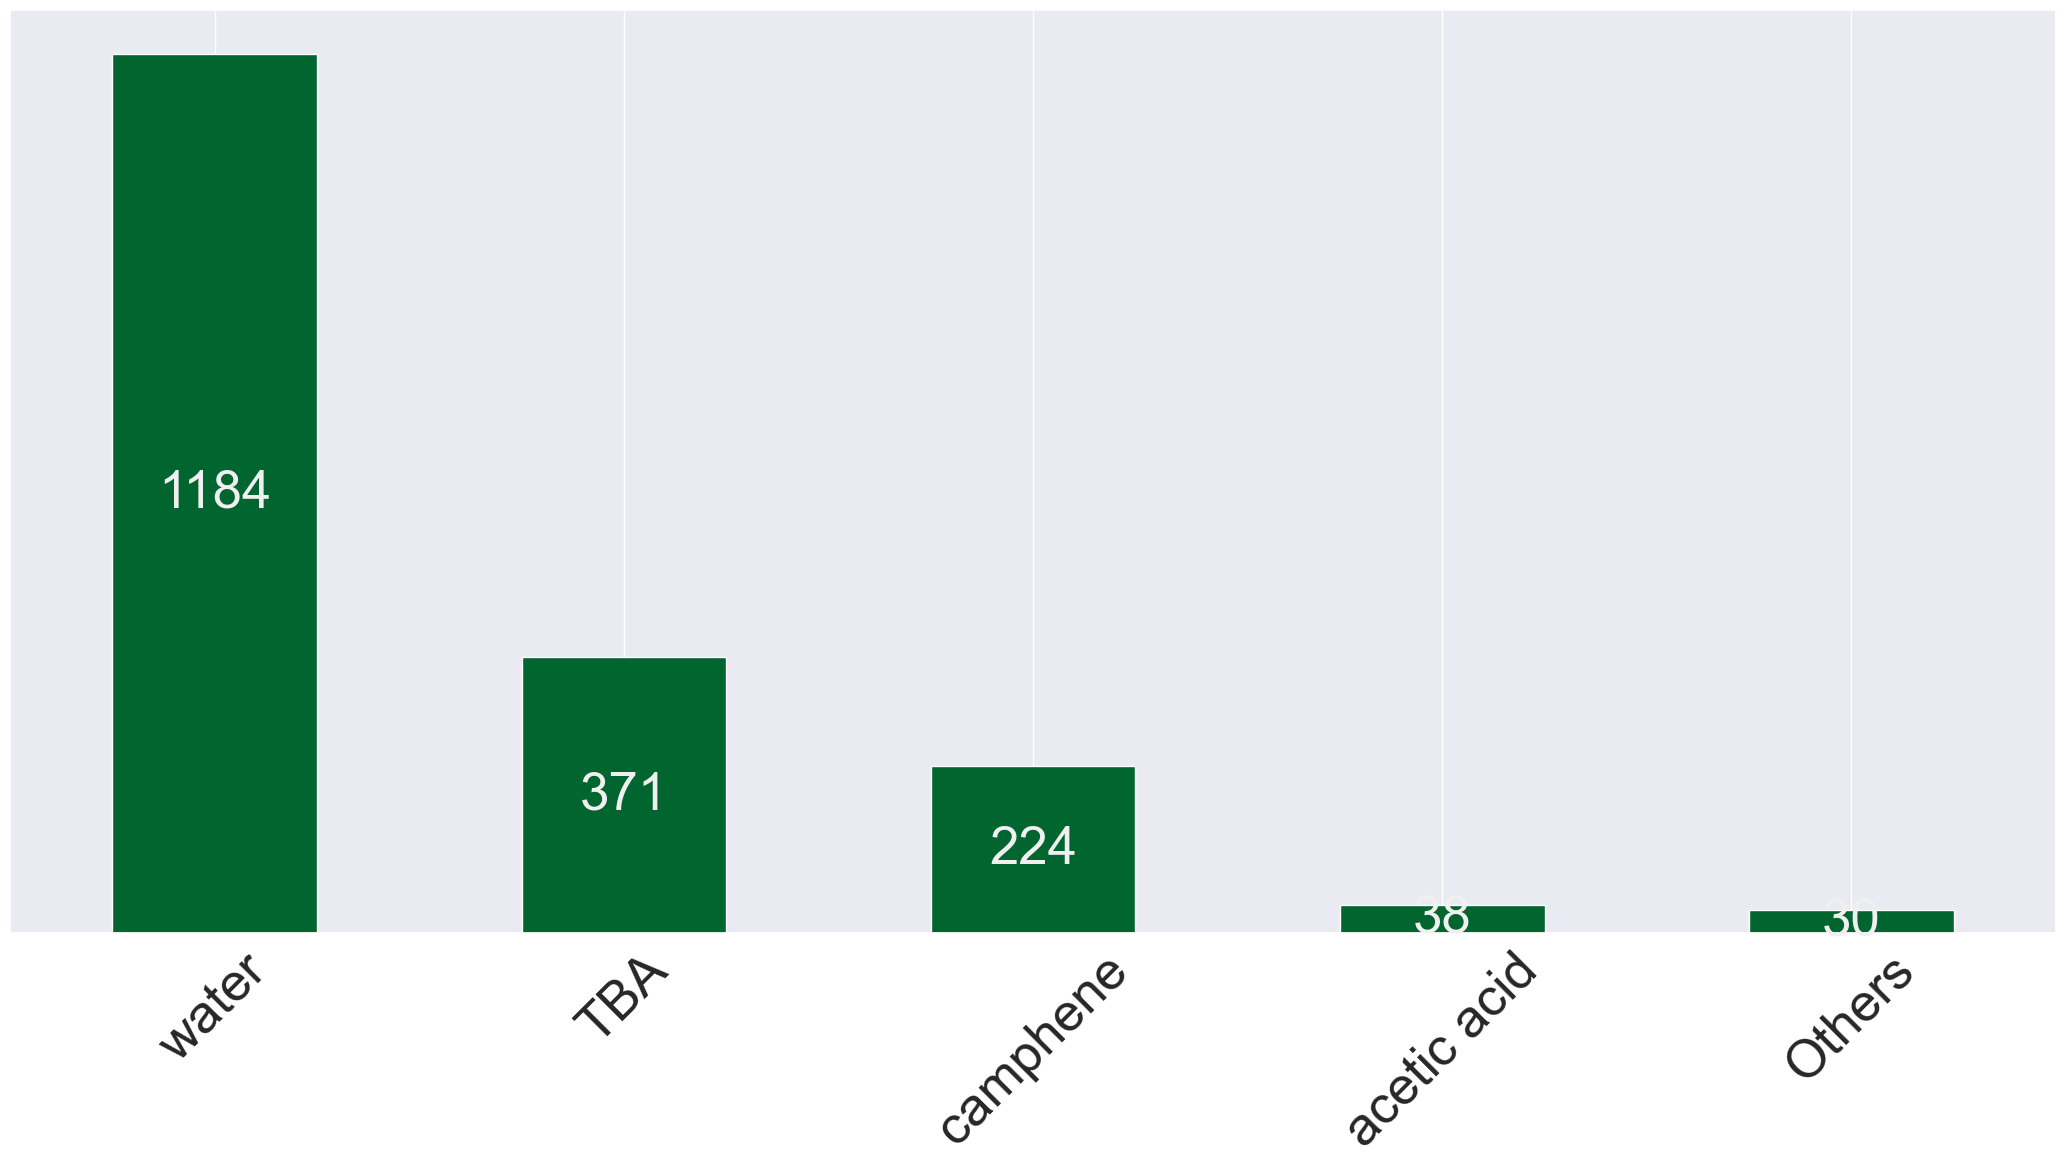

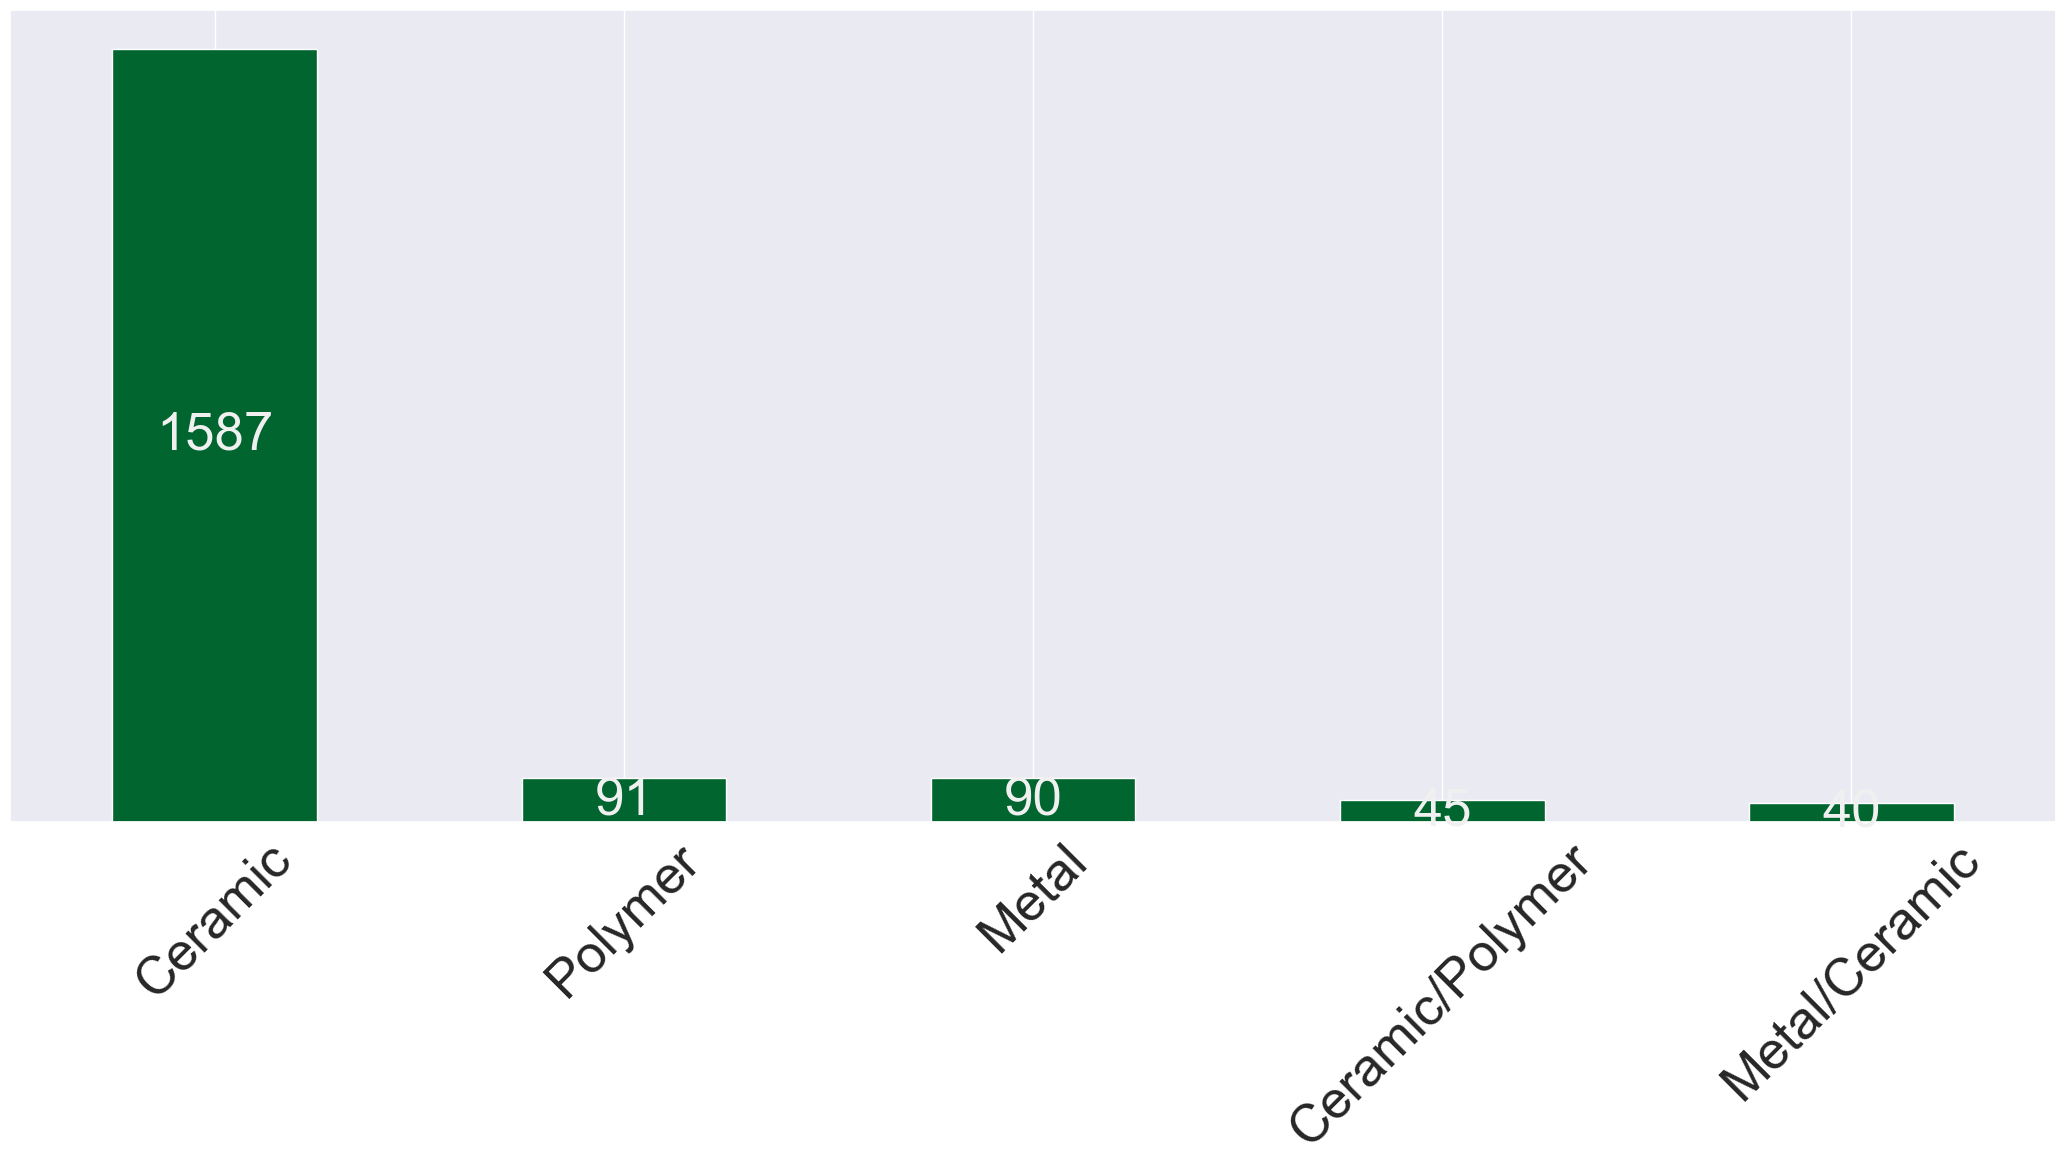

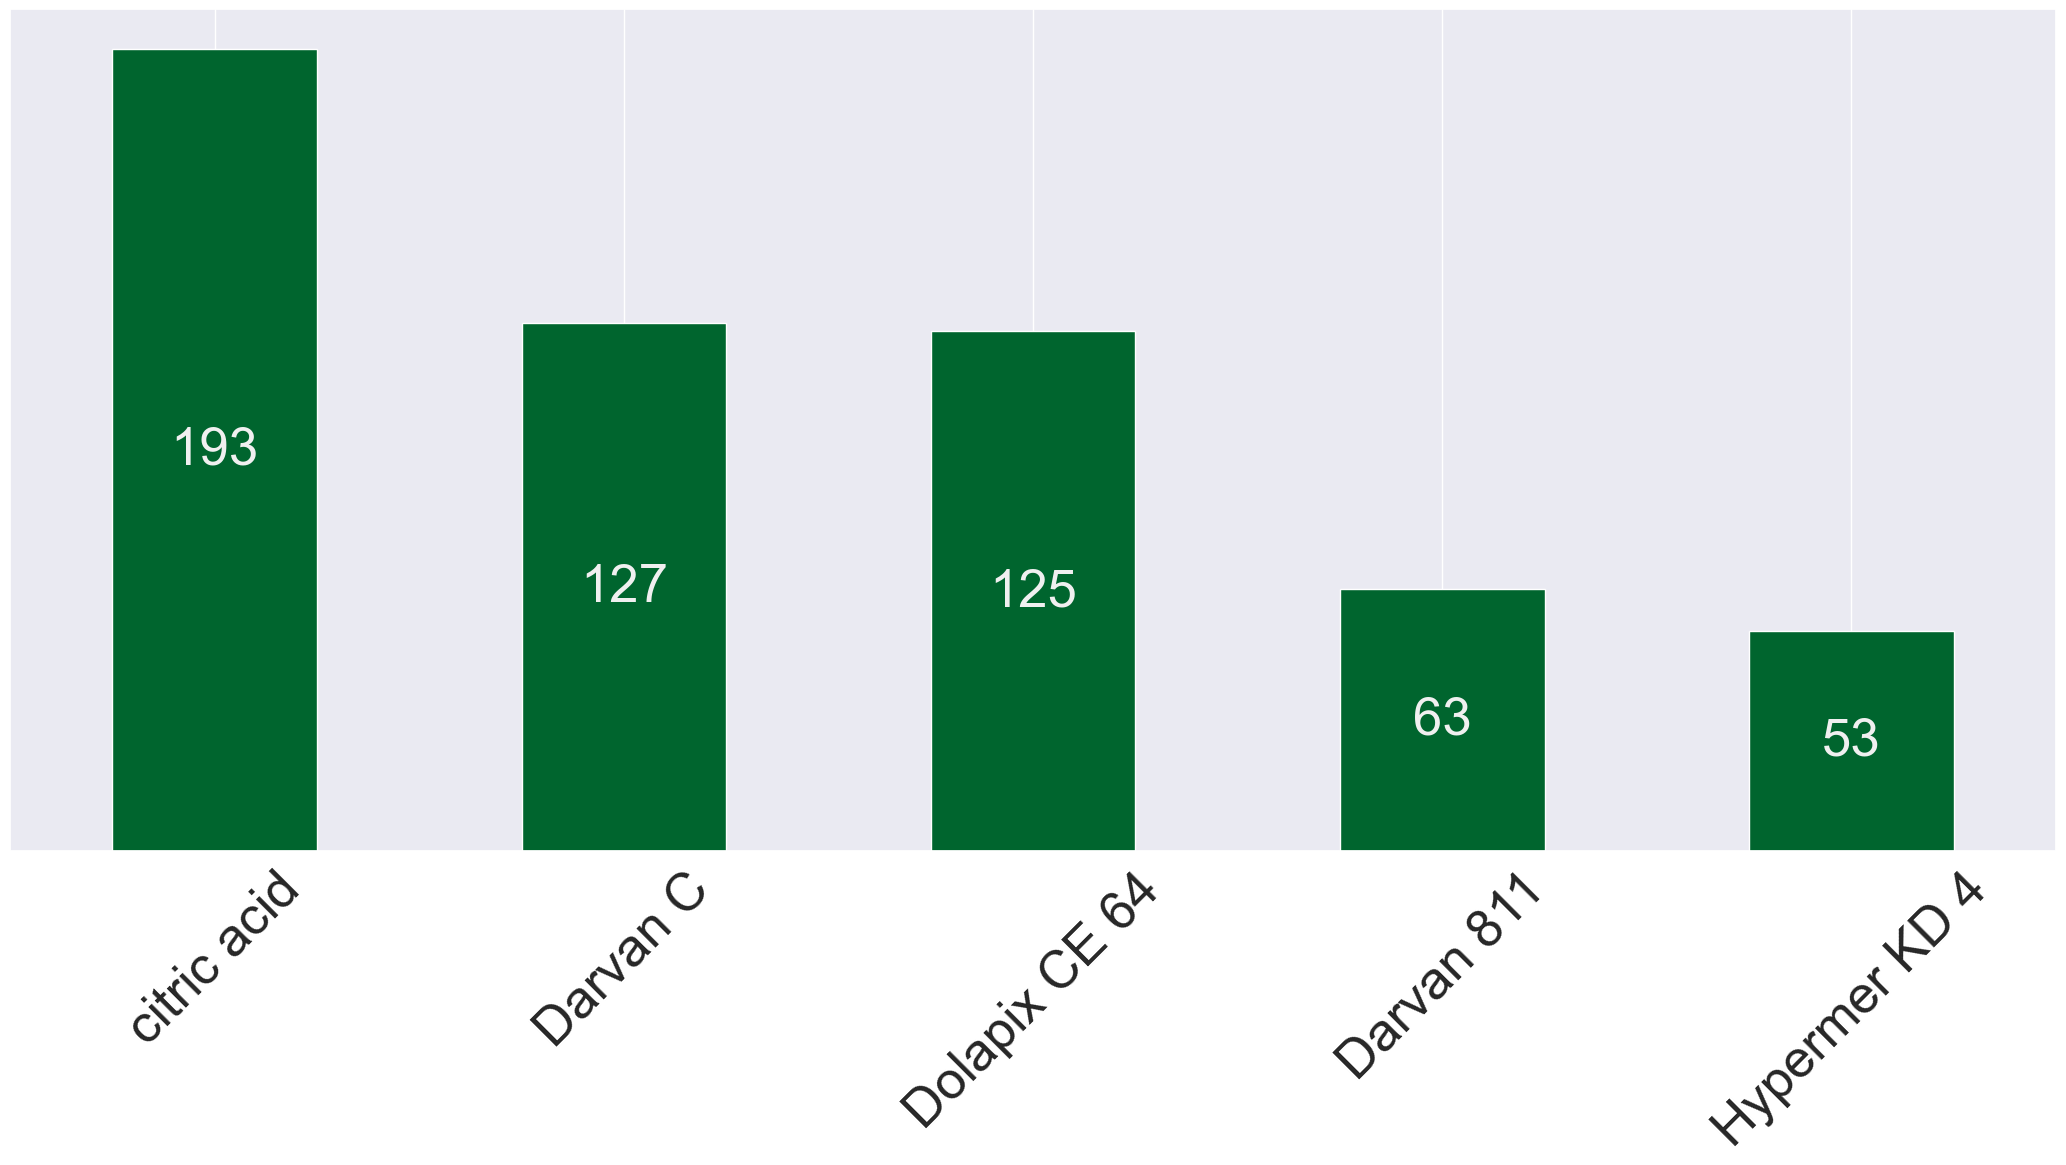

In [12]:
# Plot porosidade against string columns

# df_str = (df.select_dtypes(include=[object])).dropna()
count_filter_n = 50
rank_filter_n = 5
plt.close('all')
# Count of categorical data
for col in df_str.columns:
    f = plt.figure(figsize=(21, 9))
    f.set_figheight(12)
    plt.subplots_adjust(bottom=0.4)
    # plt.suptitle(col, fontsize=48)
    top_n = 5
    top_samples = df.groupby(col)[col].count().sort_values(ascending=False)[0:top_n]
    ax = top_samples.iloc[0:top_n].sort_values(ascending=False).plot(kind="bar", fontsize=38, color="#00652e")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.bar_label(ax.containers[0], label_type='center', fontsize=38, color='#f0f0f0')
    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis.set_label_text("")
    f.tight_layout()
    f.subplots_adjust(top=0.9)
    plt.tight_layout()  # Ensure everything fits well within the plot
    plt.savefig(f"images/Count of {col}.png", dpi=dpi)

    plt.show()
# plt.close("all")


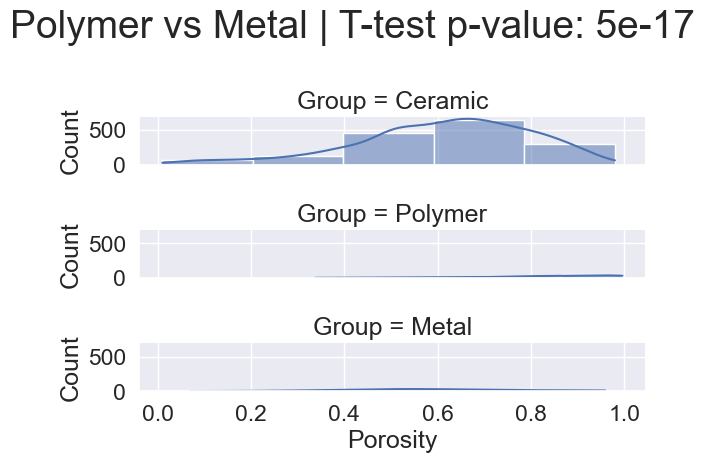

<Figure size 640x480 with 0 Axes>

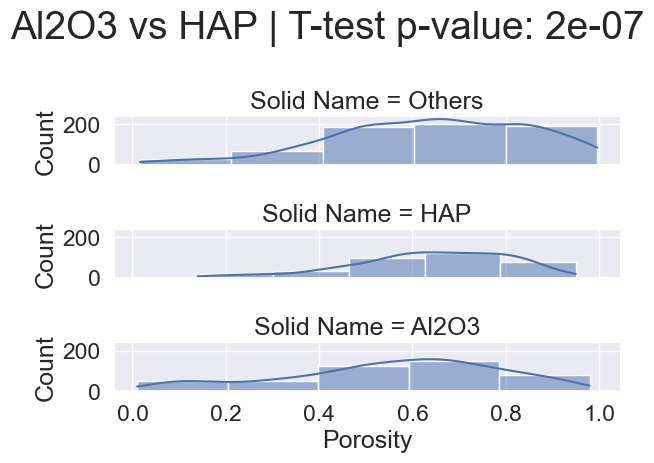

<Figure size 640x480 with 0 Axes>

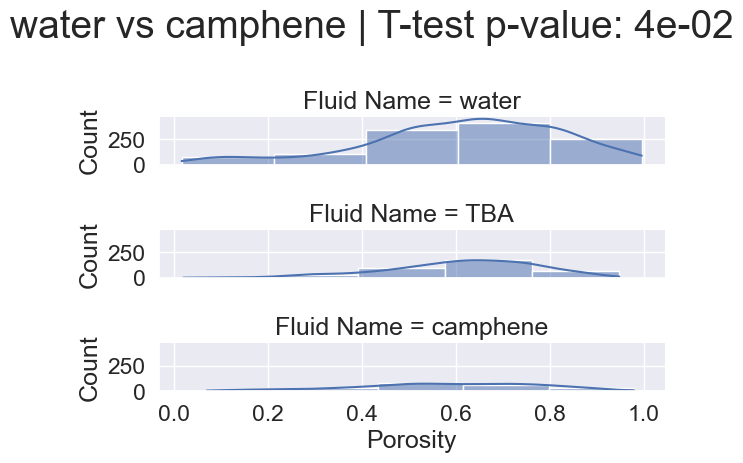

For Group, the pair with the smallest p-value is Polymer vs Metal with p-value: 4.65e-17
For Solid Name, the pair with the smallest p-value is Al2O3 vs HAP with p-value: 1.53e-07
For Fluid Name, the pair with the smallest p-value is water vs camphene with p-value: 4.28e-02


<Figure size 640x480 with 0 Axes>

In [13]:
# Define statistical test function
stat_test = ttest_ind  # One-way ANOVA

# Set the name of the statistical test for display purposes
stat_test_name = "T-test"  # Default name for ANOVA (can be changed accordingly)

# Initialize dictionary to store results
p_values_dict = {}

# Iterate over different group variables
for group_col in categorical_columns:
    # Get the top 3 most frequent groups in this categorical column
    top_groups = df[group_col].value_counts().index[:3]

    # Filter dataset to only include these top groups
    df_filtered = df[df[group_col].isin(top_groups)]

    # Determine the minimum sample size among the top 3 groups
    min_sample_size = min(df_filtered[df_filtered[group_col] == group].shape[0] for group in top_groups)

    # Sample the same number of observations for each group
    balanced_group_data = [df_filtered[df_filtered[group_col] == group].sample(min_sample_size, random_state=42)['Porosity'].dropna()
                           for group in top_groups]

    # Compute p-values for all pairs of groups
    p_values = []
    for i in range(len(balanced_group_data)):
        for j in range(i + 1, len(balanced_group_data)):
            stat, p_value = stat_test(balanced_group_data[i], balanced_group_data[j])
            p_values.append((top_groups[i], top_groups[j], p_value))

    # Sort p-values to find the smallest one
    p_values_sorted = sorted(p_values, key=lambda x: x[2])

    # Get the pair with the smallest p-value
    category1, category2, min_p_value = p_values_sorted[0]

    # Save the result for this categorical feature
    p_values_dict[group_col] = (category1, category2, min_p_value)

    # Prepare the title for the plot
    title = f'{category1} vs {category2} | {stat_test_name} p-value: {min_p_value:.0e}'

    # Create FacetGrid plot using histogram (bin plot) and KDE
    g = sns.FacetGrid(df_filtered, row=group_col, height=1.6, aspect=4)
    g.map(sns.histplot, 'Porosity', bins=5, kde=True)  # Use a consistent bin count

    # Set the title with line breaks
    g.fig.suptitle(title, fontsize=28)

    # Adjust spacing to ensure title doesn't overlap
    g.fig.subplots_adjust(top=0.80)  # Increase space above plot for title
    plt.tight_layout()  # Ensure everything fits well within the plot
    plt.show()
    plt.savefig(f"images/Count of {group_col}.png", dpi=dpi)

# Print out the results for all categorical columns
for group_col, (cat1, cat2, p_value) in p_values_dict.items():
    print(f"For {group_col}, the pair with the smallest p-value is {cat1} vs {cat2} with p-value: {p_value:.2e}")
